In [16]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'electronic_gen_3_testing_no_words'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [44]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [62]:
all_data = all_data[(all_data['class'] == 'LETTERS') | (all_data['class'] == 'ELECTRONIC')]
all_data = all_data[all_data['after'].str.len() > 5]
all_data.sample(2)
len(all_data)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
6489685,493485,20,LETTERS,OPIS,o p i s,LETTERS,"[25, 24, 31, 17, 0]",examples of u . s . tax shelters include : for...
7698043,583566,20,LETTERS,A.C.A.P.,a c a p,LETTERS,"[22, 21, 22, 24, 0]",within the first two years of his career in 19...


32992

In [63]:
sample_data = all_data.copy()
sample_data = sample_data.reset_index(drop=True)
del(all_data)

sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] == 'ELECTRONIC']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

In [64]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS']
2


In [65]:
sample_data.sample(2)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
11099,255315,20,ELECTRONIC,mlive.com,m l i v e dot c o m,ELECTRONIC,"[32, 42, 31, 54, 28, 74, 21, 25, 32, 0]",""" meet michigan 's next house speaker : kevin ..."
28044,633799,0,LETTERS,KTAV,k t a v,LETTERS,"[59, 30, 22, 54, 0]","<SAMPLE> publishing house , p . 107 ."


### Utils stuff

In [66]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


In [67]:
arr = list(sample_data['after'])
arr = [s.split(' ') for s in arr]
words_after = [EOS_TOKEN, SOS_TOKEN, UNKNOWN_WORD_TOKEN, NUMBER_WORD_TOKEN, SAMPLE_WORD_TOKEN]
words_after = words_after + sorted(list(set(np.concatenate(arr))))
words_after_index = dict((c, i) for i, c in enumerate(words_after))
words_after_by_length = sorted(words_after, key=len, reverse=True)
words_after_regex = re.compile('(' + ')|('.join(words_after_by_length) + ')')

In [68]:
len(words_after)

152

chars_after = [EOS_TOKEN, SOS_TOKEN] + sorted(list(set(list(''.join(list(sample_data['after']))))))
chars_after_index = dict((c, i) for i, c in enumerate(chars_after))
''.join(chars_after)

In [70]:
def after_sentence_to_word_indexes(sentence, include_eos=True):
    reg = re.finditer(words_after_regex, sentence)
    arr = [words_after_index[s[0]] for s in reg]
    if include_eos:
        arr += [words_after_index[EOS_TOKEN]]
    return arr
tmp = after_sentence_to_word_indexes('dot d o c')
tmp
[words_after[t] for t in tmp]

[32, 26, 92, 19, 0]

['dot', 'd', 'o', 'c', '<EOS>']

In [71]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 152])

### Samples

In [80]:
balanced_data_length = len(sample_data)
def get_random_sample():
    #sample_row = balanced_data_sample_row()
    sample_row = balanced_data_last_sample = sample_data.iloc[random.randint(1, balanced_data_length-1)]
    
    a_words_ind = after_sentence_to_word_indexes(sample_row['after'], include_eos=True)
    return sample_row['before'], a_words_ind
            
def tmp():
    s_bef, s_aft = get_random_sample()
    s_aft_str = ' '.join([words_after[i] for i in s_aft])
    print(s_bef, '->', s_aft_str, s_aft)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

NYtimes.com -> n y t i m e s dot c o m <EOS> [87, 147, 124, 65, 82, 33, 113, 32, 19, 92, 82, 0]
torch.Size([1, 12, 104])


In [23]:
%%timeit
get_random_sample()

137 µs ± 1.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [81]:
use_cuda = True

In [85]:
MAX_ATTENTION_LENGTH = 50

In [86]:
tmp = sample_data[sample_data['before'].str.len()>MAX_ATTENTION_LENGTH]
len(tmp)
tmp.sample(2)
tmp[~tmp['before'].str.contains('/')].sample(2)

498

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
19487,453003,7,ELECTRONIC,http://www.verfassungen.de/de/de33-45/wehrmach...,h t t p colon slash slash w w w dot v e r f a ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...","52 , p . 609 see : <SAMPLE> , telford ."
28222,637870,7,ELECTRONIC,http://chesstournamentservices.com/cca/2009/04...,h t t p colon slash slash c h e s s t o u r n ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 21, 45, 28, 17...",""" sadvakasov sneaks past shulman "" ( <SAMPLE> ."


,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
11533,265794,3,ELECTRONIC,2000Myspace.comTempleofschlock.blogpsot.comBil...,t w o o o o m y s p a c e dot c o m t e m p l ...,ELECTRONIC,"[30, 52, 25, 25, 25, 25, 32, 86, 17, 24, 22, 2...","7th edn , <SAMPLE> vol 89 # 8 ( 26 february 19..."
21453,491251,1,ELECTRONIC,StoneDeadline.comDeadline.comDeadline.comDeadl...,s t o n e d e a d l i n e dot c o m d e a d l ...,ELECTRONIC,"[17, 30, 25, 29, 28, 26, 28, 22, 26, 42, 31, 2...",deadline . comdeadline . comvarietydeadline . ...


### Encoder

In [108]:
class EncoderRNN(nn.Module):
    def __init__(self, chars_input_size, chars_hidden_size, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.chars_layers = chars_layers
        self.chars_hidden_size = chars_hidden_size

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size, chars_layers,
                                 batch_first=True, bidirectional=False)
                                #batch_first=True, bidirectional=True)
        
    def forward(self, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_chars = self.init_hidden()
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.chars_hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = all_outputs_chars[0, ei]
                
        #return output, all_outputs_chars
        return output_chars[0], hidden_states_cat

    def init_hidden(self):
        var2_1 = Variable(torch.zeros(1 * self.chars_layers, 1, self.chars_hidden_size))
        var2_2 = Variable(torch.zeros(1 * self.chars_layers, 1, self.chars_hidden_size))
        
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return (var2_1, var2_2)
    
    
encoder_rnn = EncoderRNN(chars_input_size=len(chars_normal),
                         chars_hidden_size=256, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_chars): LSTM(104, 256, batch_first=True)
)

In [109]:
def test_encoder_single_sample():
    s_bef, s_aft = get_random_sample()

    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

'SUPW'

torch.Size([256])

torch.Size([50, 256])

True

### Decoder

In [112]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.max_length = max_length
        
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=False)
        self.lin_out = nn.Linear(hidden_size, input_size)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        rnn_input = torch.cat((embedded[0], attn_applied[0]), 1)
        rnn_input = self.attn_combine(rnn_input).unsqueeze(0)
        rnn_input = F.relu(rnn_input)
        
        output, hidden = self.rnn(rnn_input, hidden)
        output = F.log_softmax(self.lin_out(output[0]))
        
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
#[v.size() for v in tmp]

DecoderRNN (
  (emb_lin): Linear (152 -> 256)
  (attn): Linear (512 -> 50)
  (attn_combine): Linear (512 -> 256)
  (dropout): Dropout (p = 0.1)
  (rnn): GRU(256, 256, batch_first=True)
  (lin_out): Linear (256 -> 152)
)

In [113]:
sos_tensor.size()
tmp_hiddens.size()
tmp_outputs.size()

torch.Size([1, 1, 152])

torch.Size([1, 1, 256])

torch.Size([50, 256])

In [118]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 152]), torch.Size([1, 1, 256]), torch.Size([1, 50])]

Variable containing:
 45
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

fitnesstuesday


# Training etc

### Accuracy

In [124]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft = sample
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(string_t)
        
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('fitnesstuesday fitnesstuesday s s s s s s s s s s s s s s s s s s',
 'fitnesstuesday fitnesstuesday s s s s s s s s s s s s s s s s s s',
 'i n e g i',
 ('INEGI', [65, 87, 33, 52, 65, 0]))

In [127]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', '' ))
print_local_wrong_predictions(2)

ECFC           => fitnesstuesday fitnesstuesday fitnesstuesday s s s s s s s s s s s s s s s s s || [33, 19, 39, 19, 0] 
                  
CDP's          => fitnesstuesday fitnesstuesday s s s s s s s s s s s s s s s s s s || [19, 26, 101, 0] 
                  


In [28]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 2.34 s, sys: 20 ms, total: 2.36 s
Wall time: 2.35 s


0.0

### Training

In [132]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [136]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft = get_random_sample()
        s_sentence=''
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [137]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/electronic_gen_3_testing_no_words


In [138]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   5.008   |   5.02: RCBL -> s s s s s (✗: r c b l) (forcing)
Saved model to data/models/electronic_gen_3_testing_no_words/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (  5m 17s)   4.823   |   4.94: USNO -> s s s s s (✗: u s n o) (forcing)
    27  54% (  5m 17s)   4.626   |   1.36: /ˈmɒl.li -> s s (✗: s l a s h m l dot l i) 
    36  72% (  5m 17s)   4.089   |   0.90: ESSENTIALE -> s (✗: e s s e n t i a l e) 
    45  90% (  5m 18s)   4.175   |   4.91: UCLA -> s <EOS> <EOS> <EOS> (✗: u c l a) (forcing)


In [139]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 8s)   2.415   |   1.55: ew.com -> i s (✗: e w dot c o m) 


In [140]:
train_iterations(n_iters=99000, print_every=10000)

 11000  10% (  4m 18s)   0.369   |   0.29: CEDEJ -> c e d e l (✗: c e d e j) (forcing)
 21000  20% (  8m 45s)   0.270   |   0.01: SRJC -> s r j c (✓) (forcing)
 31000  30% ( 12m 56s)   0.155   |   0.01: IIHF -> i i h f (✓) 
 41000  40% ( 17m 19s)   0.178   |   0.03: KTHV -> k t h v (✓) (forcing)
Saved model to data/models/electronic_gen_3_testing_no_words/50000_(EncoderRNN/DecoderRNN)
Accuracy: 85.02% (    8502/   10000)
 51000  51% ( 22m 51s)   0.203   |   0.00: BSIE -> b s i e (✓) 


KeyboardInterrupt: 

In [ ]:
train_iterations(n_iters=100000, print_every=10000)

### Show attention

input:   UEFA.comWebster
output:  u e f a dot c o m w e b s t e r
target:    uefadotcomwebster


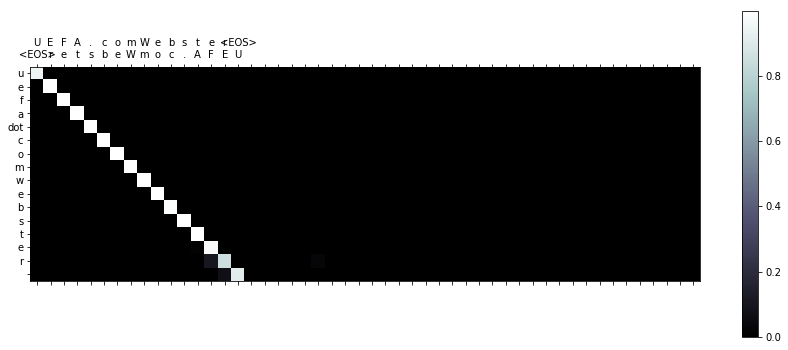

In [173]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input:  ', sample[0])
    print('output: ', ' '.join(decoded_output))
    print('target:   ', ''.join([words_after[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()